# Visualizing intermediate activations
Visualizing intermediate activations consists in displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its "activation", the output of the activation function).

In [1]:
#imports

#general imports
import os
import numpy as np

# keras imports
from keras import models
from keras import backend as K
from keras.models import load_model
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

# visual imports
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Loading a saved model and printing a summary

you can download model weights from the  [link](https://model-specific-public-storage.s3.amazonaws.com/deep_learning_with_keras/Deep_learning_for_computer_vision/model_weights.zip)


In [2]:
dir_path = os.getcwd()
path_to_model = dir_path+"/model_weights/cats_and_dogs_small_2.h5"
model = load_model(path_to_model)
model.summary()  # As a reminder.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

### Preprocessing a single image

(1, 150, 150, 3)


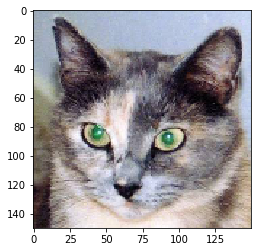

In [25]:
img_path = os.getcwd()+'/pics/cat.1700.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.
# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

plt.imshow(img_tensor[0])

### Instantiating a Model from an input tensor and a list of output tensors & running

In [5]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]

### Plotting the 4th channel of the activation of the first layer of the original model

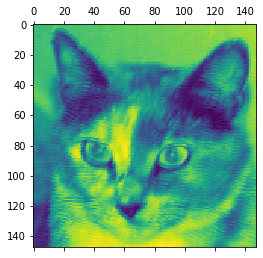

In [6]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

### Plotting the 7th channel of the activation of the first layer of the original model

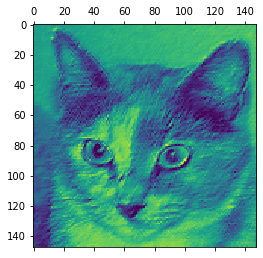

In [7]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

### Visualizing every channel in every intermediate activation

/home/sj-ai-lsb/anaconda3/envs/francois/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


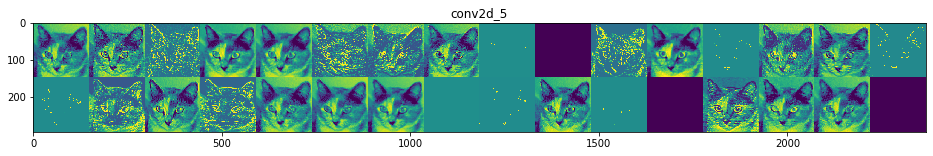

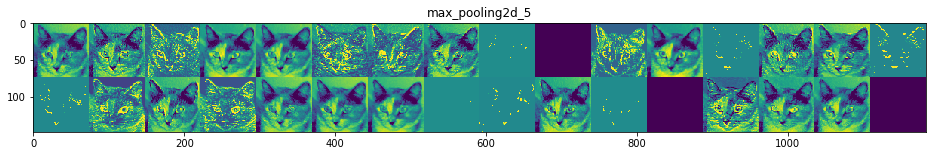

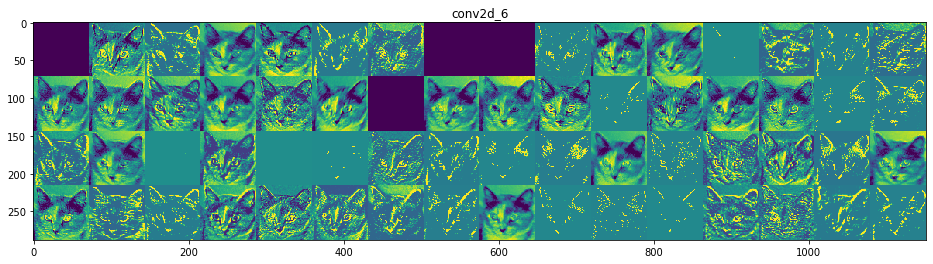

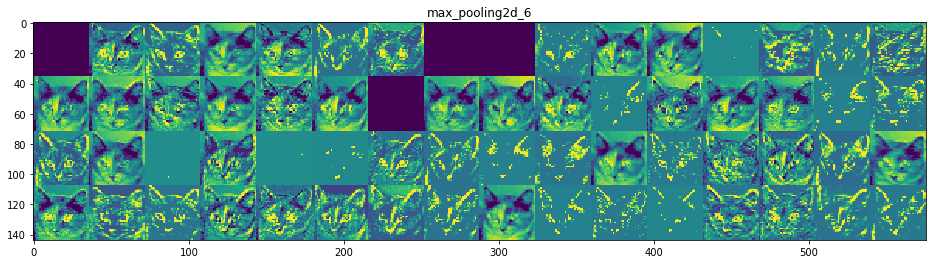

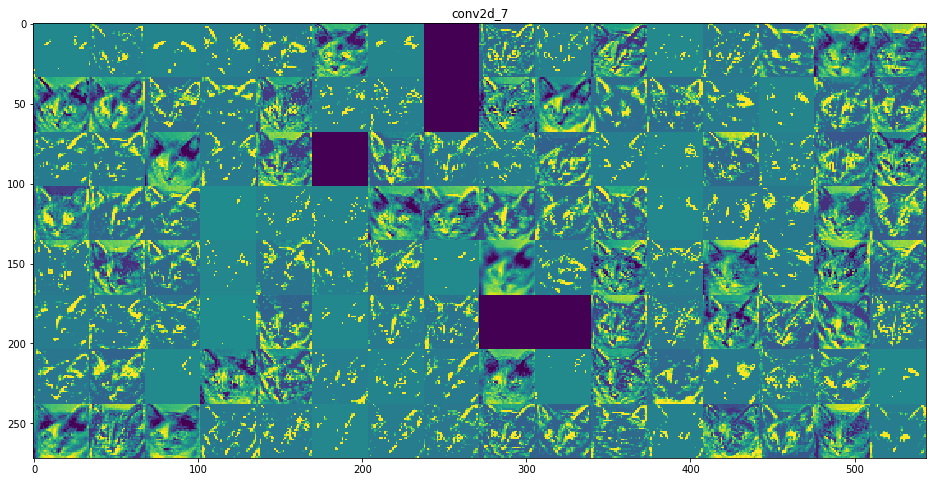

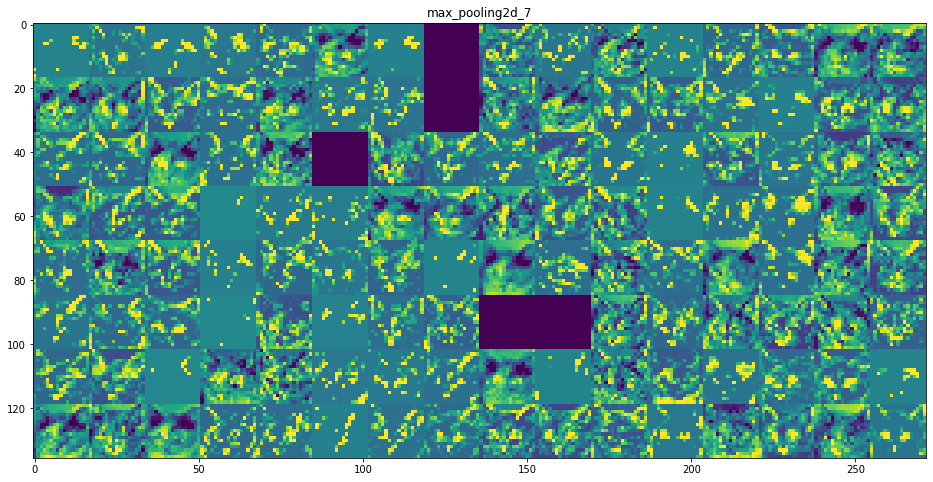

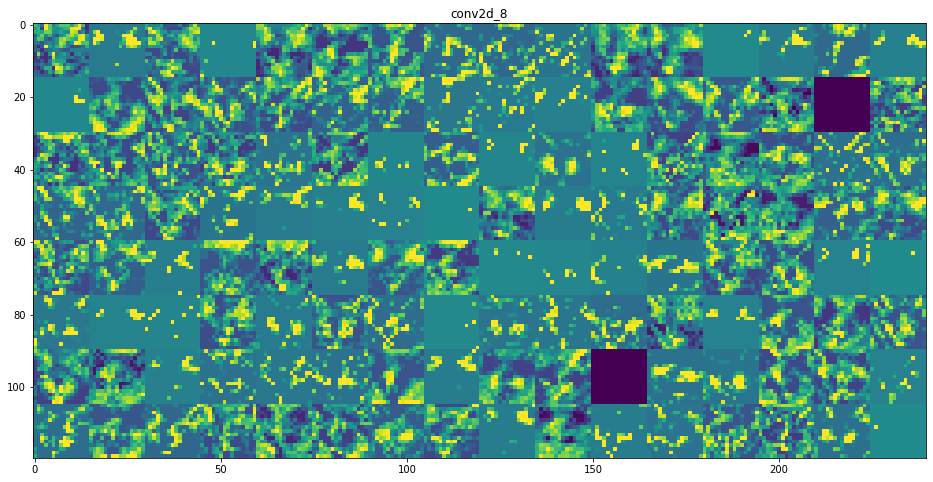

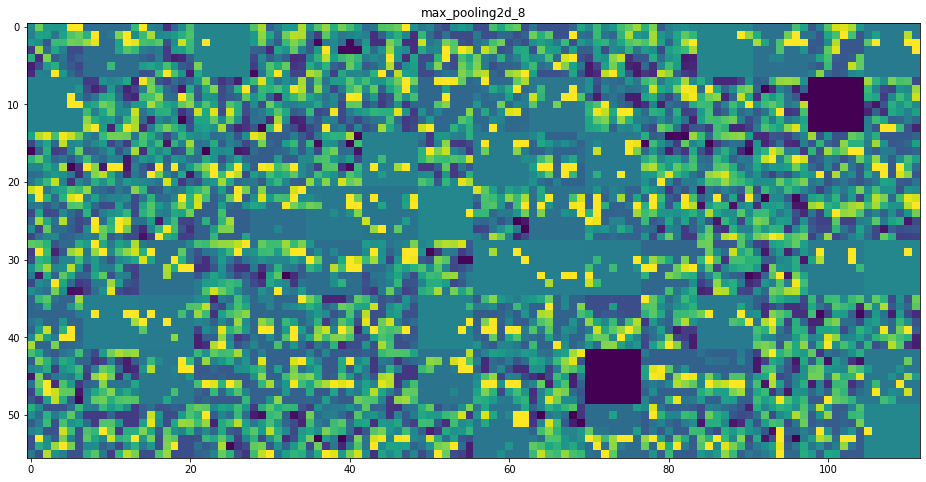

In [8]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
images_per_row = 16
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]
    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Visualizing convnet filters
Another easy thing to do to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. This can be done with gradient ascent in input space: applying gradient descent to the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a blank input image.

### Defining the loss tensor for filter visualization

In [9]:
model = VGG16(weights='imagenet',
              include_top=False)
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

### Obtaining the gradient of the loss with regard to the input

In [10]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]

### The gradient normalization trick

In [11]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads])
# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

### Loss maximization via stochastic gradient descent over the input parameters

In [12]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

### Utility function to convert a tensor into a valid image

In [13]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Putting it all together: a function to generate filter visualizations

In [14]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]
    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

### Visualising the response patterns of filter 0 of block3_conv1

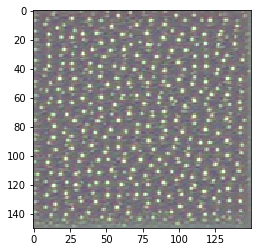

In [15]:
plt.imshow(generate_pattern('block3_conv1', 0))

### Generating of grid of all filter response patterns in a layer

In [ ]:
layer_name = 'block1_conv1'
size = 64
margin = 5
# This a empty (black) image where we will store our results.
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
for i in range(8): # iterate over the rows of our results grid
     for j in range(8): # iterate over the columns of our results grid
         # Generate the pattern for filter `i + (j * 8)` in `layer_name`
         filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
         # Put the result in the square `(i, j)` of the results grid
         horizontal_start = i * size + i * margin
         horizontal_end = horizontal_start + size
         vertical_start = j * size + j * margin
         vertical_end = vertical_start + size
         results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
# Display the results grid
plt.figure(figsize=(20, 20))
plt.imshow(results)

## Visualizing heatmaps of class activation

### Pre-processing an input image for VGG16 and predicting

In [21]:
# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

# The local path to our target image
img_path = os.getcwd()+'/pics/creative_commons_elephant.jpg'
# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))
# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)
# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)
# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

# Predicting the class of our image
preds = model.predict(x)
print ('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354576)]


## Setting up the Grad-CAM algorithm

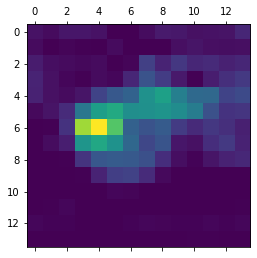

In [22]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]
# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')
# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))
# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])
# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

## Superimposing the heatmap with the original picture, and saving it to disk

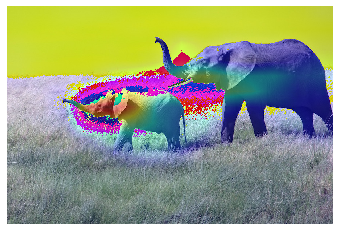

In [23]:
# We use cv2 to load the original image
img = cv2.imread(img_path)
# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img
superimposed_img= np.array(superimposed_img,np.uint8)
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(superimposed_img)
plt.show()